In [1]:
import os, sys, csv

filepath = 'annotation_results/reasoning-chain-study.csv'

In [2]:
name_to_score = {
    'Fully Supportive': 5,
    'Mostly Supportive': 4,
    'Moderately Supportive': 3,
    'Slightly Supportive': 2,
    'Not Supportive At All': 1,
}

score_to_name = {v:k for k,v in name_to_score.items()}

In [4]:
def load_annotation(path):
    anno_data = []
    with open(path, 'r') as infile:
        csvreader = csv.reader(infile, delimiter=',', quotechar='"')
        for idx, row in enumerate(csvreader):
            
            if idx == 0: continue
            instance_id = f"{row[0]}_{row[6]}"
            rating = row[-1]
            p = row[7]

            anno_data.append((float(name_to_score[rating]), float(p)))

    return anno_data

In [5]:
def format_row(row):
    question = row[1]
    answer_options = row[2].split("||")
    predicted_answer = int(row[5])
    cot = row[3].split("||")
    target_step = int(row[6])
    dmass = float(row[7])
    options = '\n'.join(answer_options)
    cot_steps = '\n'.join(cot)
    
    print(f"{question}\n{options}\nP:{answer_options[predicted_answer]}\n{cot_steps}\nT:{cot[target_step]}\nM={dmass}")

In [6]:
def bin_annotations(path):
    binned_data = {}
    with open(path, 'r') as infile:
        csvreader = csv.reader(infile, delimiter=',', quotechar='"')
        for idx, row in enumerate(csvreader):
            
            if idx == 0: continue
            instance_id = f"{row[0]}_{row[6]}"
            # print(row)
            rating = row[-1]
            p = row[7]
            # if instance_id in anno_data: print("Wtf")
            if rating not in binned_data:
                binned_data[rating] = []
            binned_data[rating].append(list(row))

    return binned_data

In [7]:
binned_data = bin_annotations(filepath)

## Analysis

In [8]:
from pprint import pprint
anno_data = load_annotation(filepath)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def correlation_plot(frame, title_prefix=""):
    plt.figure(figsize=(4, 3))
    corr = pearsonr(frame['rating'], frame['dmass'])
    
    plt.scatter(frame['rating'], frame['dmass'])
    if title_prefix:
        title_prefix += ": "

    plt.title(f"{title_prefix}Corr={corr.statistic:.3f}, p={corr.pvalue:.3g}")
    plt.xlabel('Rating')
    plt.ylabel('Shifted mass')
    plt.show()

def correlation_subplots(a_dict):
    N = len(a_dict)
    fig, (axs) = plt.subplots(1, N, figsize=(16,3))

    for idx, (k, vals) in enumerate(a_dict.items()):
        E, F = list(zip(*vals))
        frame = pd.DataFrame({
            'efficacy': E,
            'faithfulness': F,
        })
        corr = pearsonr(frame['efficacy'], frame['faithfulness'])
        axs[idx].scatter(frame['efficacy'], frame['faithfulness'])
        axs[idx].set_title(f"{k}: c={corr.statistic:.3f}, p={corr.pvalue:.3g}")
    plt.show()

In [10]:
R, D = list(zip(*anno_data))

frame = pd.DataFrame({
    'rating': R,
    'dmass': D,
})

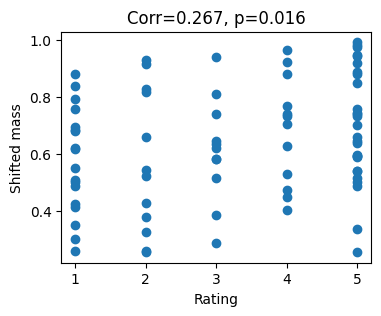

In [11]:
correlation_plot(frame)

In [12]:
binarize = {1:0, 2:0, 4:2, 5:2, 3:1}

In [13]:
binary_anno_data = [
    (binarize[int(a)], i) for a, i in anno_data # if binarize[int(a)] != 0
]

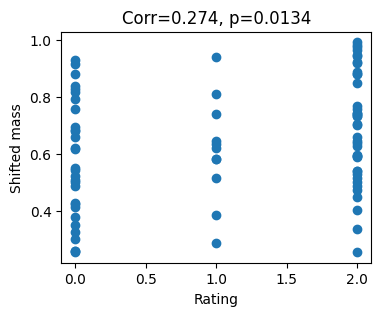

In [14]:
bR, bD = list(zip(*binary_anno_data))
binary_frame = pd.DataFrame({
    'rating': bR,
    'dmass': bD,
})
correlation_plot(binary_frame)

In [15]:
bins = {}
for R, D in anno_data:
    R = int(R)
    if R not in bins:
        bins[R] = []
    bins[R].append(D)

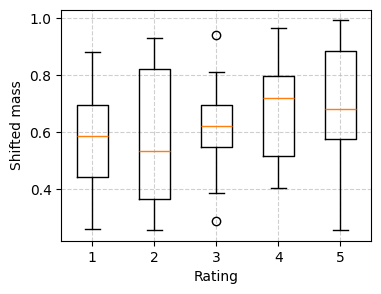

In [16]:
vals = [bins[i] for i in [1,2,3,4,5]]
plt.figure(figsize=(4, 3))
plt.boxplot(vals)

plt.xticks(ticks=[1,2,3,4,5], labels=[f'{i+1}' for i in range(5)])
plt.xlabel('Rating')
plt.ylabel('Shifted mass')
plt.grid(True, linestyle='--', alpha=0.6)